In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import set_neutral_position
import ndiff
import pandas as pd
from imp import reload
#jtplot.style()
%matplotlib inline

ppm_routines = ndiff.ppm_routines

In [2]:
# Some simple functions to set up the and perform the neutral diffusion flux calculations
def ppm_reconstruction(h, Slayer):    
    Sinterface = np.zeros(np.size(Slayer)+1, dtype=np.float32)
    ppm_routines.interface_scalar(h, Slayer, Sinterface, 2)
    Sl = np.zeros(np.size(Slayer), dtype=np.float32)
    Sr = np.zeros(np.size(Slayer), dtype=np.float32)
    ppm_routines.ppm_left_right_edge_values(Slayer.astype(np.float32), Sinterface, Sl, Sr)
    return Sl, Sr

def construct_column(h, T):
    zi = np.array(0) ; zi = np.append(zi,hl.cumsum())
    z_t = h.cumsum() - h[0]
    z_b = h.cumsum()
    z_c = h.cumsum() - 0.5*h
    T_t, T_b = ppm_reconstruction(h,T)
    
    return zi, z_t, z_b, z_c, T_t, T_b

def interp_reconstruction(T_t, T_c, T_b, P, k):
    if P == 0.:
        return T_t[k]
    if P == 1.:
        return T_b[k]
    elif P>0. and P<1.:
        T_int = np.interp( P, np.array( (0., 0.5, 1.) ), np.array( (T_t[k], T_c[k], T_b[k]) ) )
        return T_int
    else:
        print(k, P)

def plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                          zl_t, zl_c, zl_b, Tl_t, Tl, Tl_b, PoL_abs, KoL, search_dir):
    # Plot PPM reconstructon of left column
    for k in np.arange(0,hl.size):
        z = np.array( [zl_t[k], zl_c[k], zl_b[k]])
        T = np.array( [Tl_t[k], Tl[k], Tl_b[k]] )
        plt.plot(T,z, color='green')
        plt.scatter(Tl_t, zl_t, marker='^')
        plt.scatter(Tl_b, zl_b, marker='v')
    # PPM reconstruction of right column 
    for k in np.arange(0,hl.size):
        z = np.array( [zr_t[k], zr_c[k], zr_b[k]] )
        T = np.array( [Tr_t[k], Tr[k], Tr_b[k]] )
        plt.plot(T,z, color = 'cyan')
        plt.scatter(Tr_t, zr_t, marker='^')
        plt.scatter(Tr_b, zr_b, marker='v')    
    
    # Plot neutral surfaces
    for k in np.arange(0,PoR_abs.size):
        kr = KoR[k]
        Tr_int = interp_reconstruction(Tr_t, Tr, Tr_b, PoR[k], kr)
        kl = KoL[k]
        Tl_int = interp_reconstruction(Tl_t, Tl, Tl_b, PoL[k], kl)
        if search_dir[k] == 0:
            #plt.plot(np.array( (Tl_int, Tr_int) ), np.array( (PoL_abs[k],PoR_abs[k]) ) , ':', color="green" ) 
            plt.arrow( Tl_int, PoL_abs[k], Tr_int - Tl_int , PoR_abs[k] - PoL_abs[k], head_width=0.5, color="green" ) 
        else:
            plt.arrow( Tr_int, PoR_abs[k], Tl_int - Tr_int , PoL_abs[k] - PoR_abs[k], head_width=0.5, color="cyan" )
            #plt.plot(np.array( (Tl_int, Tr_int) ), np.array( (PoL_abs[k],PoR_abs[k]) ) , ':', color="cyan" ) 
        print("Surface %d:" % k, Tl_int, Tr_int, PoL_abs[k], PoR_abs[k])
    plt.xlim( (5,22.5) )
    plt.grid(ls='dotted')
    plt.xlabel('Temperature')
    plt.gca().invert_yaxis()    
        

# Overview
This notebook and accompanying code mimics how MOM6 finds the neutral surfaces along which to perform parameterized diffusion. The examples in here are based on Alistair Adcrofts schematics where density is controlled by temperature with $\alpha = -1$. Unlike his original slides, in this notebook, a discontinuous reconstruction of temperature is done with an assumed piecewise continuous reconstruction at the boundaries.

In [3]:
# Set up some examples based on Alistair's schematics of
nk = 4
Sl_t = np.zeros(nk) ; Sl_b = np.zeros(nk)
Sr_t = np.zeros(nk) ; Sr_b = np.zeros(nk)
drdt_lt = -1*np.ones(nk) ; drdt_lb = -1*np.ones(nk)
drds_lt = np.zeros(nk) ; drds_lb = np.zeros(nk)
drdt_rt = -1*np.ones(nk) ; drdt_rb = -1*np.ones(nk)
drds_rt = np.zeros(nk) ; drds_rb = np.zeros(nk)

# Identical columns

In [4]:
# Warmer on right
reload(set_neutral_position)
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Tr = np.array([20.,16.,12.,10.])
Tl = np.array([20.,16.,12.,10.])
zil, zl_t, zl_b, zl_c, Tl_t, Tl_b = construct_column(hl, Tl)
zir, zr_t, zr_b, zr_c, Tr_t, Tr_b = construct_column(hr, Tr)
PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR, search_dir = set_neutral_position.set_neutral_surface_position2(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb)
df_identical = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})


Working on k_surface 0: Tl[0,0]: 20.000000 Tr[0,0]: 20.000000 dRho: 0.000000
Searching from right layer 0 Interface 0
Searching in left layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
At top or dRhoTop>0
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000

Working on k_surface 1: Tl[0,0]: 20.000000 Tr[0,1]: 20.000000 dRho: 0.000000
Searching from left layer 0 interface 0
Searching in right layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
Layer perfectly unstratified, different search direction
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000
hL: 0.000000 hR: 0.000000 hEff: 0.000000

Working on k_surface 2: Tl[0,1]: 20.000000 Tr[0,1]: 20.000000 dRho: 0.000000
Searching from right layer 0 Interface 1
Searching in left layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
Layer perfectly unstratified, different search direction
Search top of next layer 1
Position on left layer 0: 1.000000
Position on rig

40.0
    KoL  KoR  PoL  PoR    hL    hR    zl    zr
0     1    1  0.0  0.0   0.0   0.0   0.0   0.0
1     1    1  0.0  0.0   0.0   0.0   0.0   0.0
2     1    1  1.0  1.0  10.0  10.0  10.0  10.0
3     1    1  1.0  1.0   0.0   0.0  10.0  10.0
4     2    2  0.0  0.0   0.0   0.0  10.0  10.0
5     2    2  0.0  0.0   0.0   0.0  10.0  10.0
6     2    2  1.0  1.0  10.0  10.0  20.0  20.0
7     2    2  1.0  1.0   0.0   0.0  20.0  20.0
8     2    3  1.0  0.0   0.0   0.0  20.0  20.0
9     3    3  0.0  0.0   0.0   0.0  20.0  20.0
10    3    3  1.0  1.0  10.0  10.0  30.0  30.0
11    3    3  1.0  1.0   0.0   0.0  30.0  30.0
12    4    4  0.0  0.0   0.0   0.0  30.0  30.0
13    4    4  0.0  0.0   0.0   0.0  30.0  30.0
14    4    4  1.0  1.0  10.0  10.0  40.0  40.0
15    4    4  1.0  1.0   0.0   0.0  40.0  40.0
Surface 0: 18.0 20.0 0.0 0.0
Surface 1: 18.0 20.0 0.0 0.0
Surface 2: 18.0 20.0 10.0 10.0
Surface 3: 18.0 20.0 10.0 10.0
Surface 4: 16.6667 18.6667 10.0 10.0
Surface 5: 16.6667 18.6667 10.0 10.0
Su

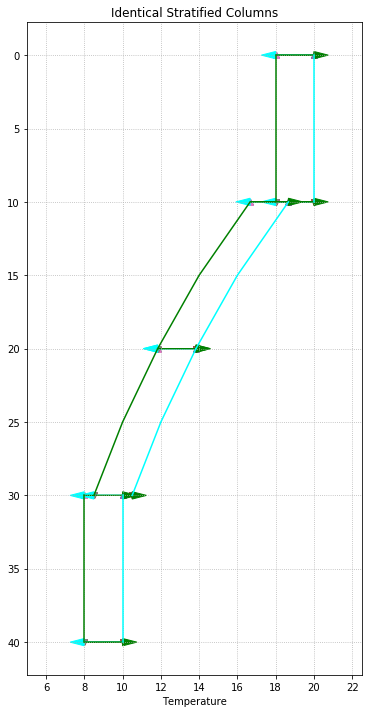

In [5]:
print(hEff.sum())
print(df_identical)
plt.figure(figsize=(6,12))
plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                      zl_t, zl_c, zl_b, Tl_t-2, Tl-2, Tl_b-2, PoL_abs, KoL, search_dir)
plt.title('Identical Stratified Columns')

In [6]:
print(df_identical)

    KoL  KoR  PoL  PoR    hL    hR    zl    zr
0     1    1  0.0  0.0   0.0   0.0   0.0   0.0
1     1    1  0.0  0.0   0.0   0.0   0.0   0.0
2     1    1  1.0  1.0  10.0  10.0  10.0  10.0
3     1    1  1.0  1.0   0.0   0.0  10.0  10.0
4     2    2  0.0  0.0   0.0   0.0  10.0  10.0
5     2    2  0.0  0.0   0.0   0.0  10.0  10.0
6     2    2  1.0  1.0  10.0  10.0  20.0  20.0
7     2    2  1.0  1.0   0.0   0.0  20.0  20.0
8     2    3  1.0  0.0   0.0   0.0  20.0  20.0
9     3    3  0.0  0.0   0.0   0.0  20.0  20.0
10    3    3  1.0  1.0  10.0  10.0  30.0  30.0
11    3    3  1.0  1.0   0.0   0.0  30.0  30.0
12    4    4  0.0  0.0   0.0   0.0  30.0  30.0
13    4    4  0.0  0.0   0.0   0.0  30.0  30.0
14    4    4  1.0  1.0  10.0  10.0  40.0  40.0
15    4    4  1.0  1.0   0.0   0.0  40.0  40.0


# Right column is slightly warmer

In [7]:
# Warmer on right
reload(set_neutral_position)
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Tr = np.array([20.,16.,12.,10.])
Tl = np.array([18.,14.,10.,8.])
zil, zl_t, zl_b, zl_c, Tl_t, Tl_b = construct_column(hl, Tl)
zir, zr_t, zr_b, zr_c, Tr_t, Tr_b = construct_column(hr, Tr)
PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR, search_dir = set_neutral_position.set_neutral_surface_position2(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb)
df_warm_right = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})


Working on k_surface 0: Tl[0,0]: 18.000000 Tr[0,0]: 20.000000 dRho: -2.000000
Searching from right layer 0 Interface 0
Searching in left layer 0: dRhoTop: 2.000000 dRhoBot: 2.000000
At top or dRhoTop>0
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000

Working on k_surface 1: Tl[0,0]: 18.000000 Tr[0,1]: 20.000000 dRho: -2.000000
Searching from right layer 0 Interface 1
Searching in left layer 0: dRhoTop: 2.000000 dRhoBot: 2.000000
At top or dRhoTop>0
Search top of next layer 1
Position on left layer 0: 0.000000
Position on right layer 0: 1.000000
hL: 0.000000 hR: 10.000000 hEff: 0.000000

Working on k_surface 2: Tl[0,0]: 18.000000 Tr[1,0]: 18.666666 dRho: -0.666666
Searching from right layer 1 Interface 0
Searching in left layer 0: dRhoTop: 0.666666 dRhoBot: 0.666666
At top or dRhoTop>0
Search bottom of same layer 1
Position on left layer 0: 0.000000
Position on right layer 1: 0.000000
hL: 0.000000 hR: 0.000000 hEff: 0.000000

Working

Surface 0: 18.0 20.0 0.0 0.0
Surface 1: 18.0 20.0 0.0 10.0
Surface 2: 18.0 18.6667 0.0 10.0
Surface 3: 18.0 17.93103467553453 0.0 11.3793091201
Surface 4: 18.0 17.93103467553453 10.0 11.3793091201
Surface 5: 16.6667 16.45976986017581 10.0 14.1379313066
Surface 6: 13.626436844733918 13.8333 15.8620686934 20.0
Surface 7: 13.626436844733918 13.8333 15.8620686934 20.0
Surface 8: 11.8333 11.699999828338607 20.0 26.0000005722
Surface 9: 11.8333 11.699999828338607 20.0 26.0000005722
Surface 10: 10.366666812896712 10.5 23.9999994278 30.0
Surface 11: 9.850000128746045 10.0 25.4999995708 30.0
Surface 12: 9.850000128746045 10.0 25.4999995708 40.0
Surface 13: 8.5 10.0 30.0 40.0
Surface 14: 8.0 10.0 30.0 40.0
Surface 15: 8.0 10.0 40.0 40.0


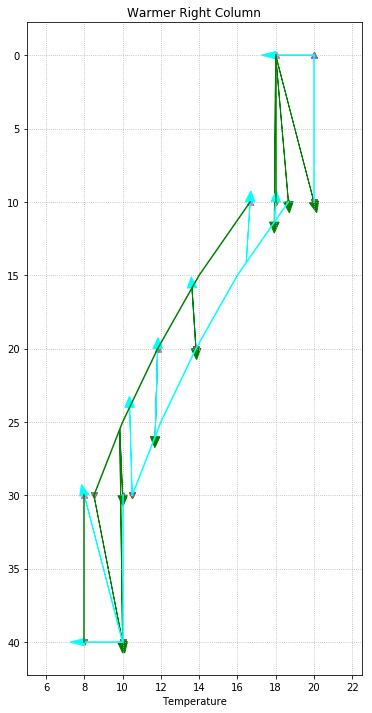

In [8]:
plt.figure(figsize=(6,12))
plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                      zl_t, zl_c, zl_b, Tl_t, Tl, Tl_b, PoL_abs, KoL, search_dir)
plt.title('Warmer Right Column')

In [9]:
print(df_warm_right)

    KoL  KoR       PoL       PoR         hL         hR         zl         zr
0     1    1  0.000000  0.000000   0.000000   0.000000   0.000000   0.000000
1     1    1  0.000000  1.000000   0.000000  10.000000   0.000000  10.000000
2     1    2  0.000000  0.000000   0.000000   0.000000   0.000000  10.000000
3     1    2  0.000000  0.137931   0.000000   1.379309   0.000000  11.379309
4     1    2  1.000000  0.137931  10.000000   0.000000  10.000000  11.379309
5     2    2  0.000000  0.413793   0.000000   2.758622  10.000000  14.137931
6     2    2  0.586207  1.000000   5.862069   5.862069  15.862069  20.000000
7     2    3  0.586207  0.000000   0.000000   0.000000  15.862069  20.000000
8     2    3  1.000000  0.600000   4.137931   6.000001  20.000000  26.000001
9     3    3  0.000000  0.600000   0.000000   0.000000  20.000000  26.000001
10    3    3  0.400000  1.000000   3.999999   3.999999  23.999999  30.000000
11    3    4  0.550000  0.000000   1.500000   0.000000  25.500000  30.000000

# Much Cooler on right

In [10]:
reload(set_neutral_position)
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Tr = np.array([8., 4., 0., -4.])
Tl = np.array([20., 16., 12.,8.])
Sl_t = np.zeros(hl.size) ; Sl_b = np.zeros(hl.size)
Sr_t = np.zeros(hl.size) ; Sr_b = np.zeros(hl.size)
drdt_lt = -1*np.ones(hl.size) ; drdt_lb = -1*np.ones(hl.size)
drds_lt = np.zeros(hl.size) ; drds_lb = np.zeros(hl.size)
drdt_rt = -1*np.ones(hl.size) ; drdt_rb = -1*np.ones(hl.size)
drds_rt = np.zeros(hl.size) ; drds_rb = np.zeros(hl.size)
zil, zl_t, zl_b, zl_c, Tl_t, Tl_b = construct_column(hl, Tl)
zir, zr_t, zr_b, zr_c, Tr_t, Tr_b = construct_column(hr, Tr)
PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR, search_dir = set_neutral_position.set_neutral_surface_position2(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb)
df_cool_right = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})


Working on k_surface 0: Tl[0,0]: 20.000000 Tr[0,0]: 8.000000 dRho: 12.000000
Searching from left layer 0 interface 0
Searching in right layer 0: dRhoTop: 12.000000 dRhoBot: 12.000000
At top or dRhoTop>0
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000

Working on k_surface 1: Tl[0,1]: 20.000000 Tr[0,0]: 8.000000 dRho: 12.000000
Searching from left layer 0 interface 1
Searching in right layer 0: dRhoTop: 12.000000 dRhoBot: 12.000000
At top or dRhoTop>0
Search top of next layer 1
Position on left layer 0: 1.000000
Position on right layer 0: 0.000000
hL: 10.000000 hR: 0.000000 hEff: 0.000000

Working on k_surface 2: Tl[1,0]: 18.666666 Tr[0,0]: 8.000000 dRho: 10.666666
Searching from left layer 1 interface 0
Searching in right layer 0: dRhoTop: 10.666666 dRhoBot: 10.666666
At top or dRhoTop>0
Search bottom of same layer 1
Position on left layer 1: 0.000000
Position on right layer 0: 0.000000
hL: 0.000000 hR: 0.000000 hEff: 0.000000

Work

Surface 0: 20.0 8.0 0.0 0.0
Surface 1: 20.0 8.0 10.0 0.0
Surface 2: 18.6667 8.0 10.0 0.0
Surface 3: 14.0 8.0 20.0 0.0
Surface 4: 14.0 8.0 20.0 0.0
Surface 5: 9.33333 8.0 30.0 0.0
Surface 6: 8.0 8.0 30.0 0.0
Surface 7: 8.0 8.0 30.0 0.0
Surface 8: 8.0 8.0 40.0 10.0
Surface 9: 8.0 8.0 40.0 10.0
Surface 10: 8.0 6.66667 40.0 10.0
Surface 11: 8.0 2.0 40.0 20.0
Surface 12: 8.0 2.0 40.0 20.0
Surface 13: 8.0 -2.66667 40.0 30.0
Surface 14: 8.0 -4.0 40.0 30.0
Surface 15: 8.0 -4.0 40.0 40.0


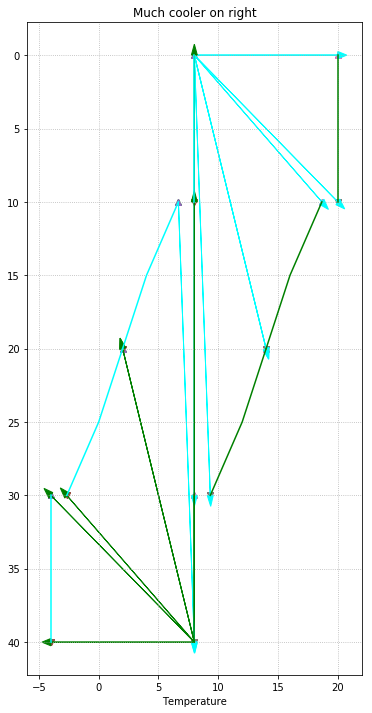

In [11]:
plt.figure(figsize=(6,12))
plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                      zl_t, zl_c, zl_b, Tl_t, Tl, Tl_b, PoL_abs, KoL, search_dir)
plt.xlim((-6,22))
plt.title('Much cooler on right')

In [12]:
print(df_cool_right)

    KoL  KoR  PoL  PoR    hL    hR    zl    zr
0     1    1  0.0  0.0   0.0   0.0   0.0   0.0
1     1    1  1.0  0.0  10.0   0.0  10.0   0.0
2     2    1  0.0  0.0   0.0   0.0  10.0   0.0
3     2    1  1.0  0.0  10.0   0.0  20.0   0.0
4     3    1  0.0  0.0   0.0   0.0  20.0   0.0
5     3    1  1.0  0.0  10.0   0.0  30.0   0.0
6     4    1  0.0  0.0   0.0   0.0  30.0   0.0
7     4    1  0.0  0.0   0.0   0.0  30.0   0.0
8     4    1  1.0  1.0  10.0  10.0  40.0  10.0
9     4    1  1.0  1.0   0.0   0.0  40.0  10.0
10    4    2  1.0  0.0   0.0   0.0  40.0  10.0
11    4    2  1.0  1.0   0.0  10.0  40.0  20.0
12    4    3  1.0  0.0   0.0   0.0  40.0  20.0
13    4    3  1.0  1.0   0.0  10.0  40.0  30.0
14    4    4  1.0  0.0   0.0   0.0  40.0  30.0
15    4    4  1.0  1.0   0.0  10.0  40.0  40.0


# Identical Unstratified Column

In [13]:
reload(set_neutral_position)
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Tr = np.array([0., 0., 0., 0.,])
Tl = np.array([0., 0., 0., 0.,])
Sl_t = np.zeros(hl.size) ; Sl_b = np.zeros(hl.size)
Sr_t = np.zeros(hl.size) ; Sr_b = np.zeros(hl.size)
drdt_lt = -1*np.ones(hl.size) ; drdt_lb = -1*np.ones(hl.size)
drds_lt = np.zeros(hl.size) ; drds_lb = np.zeros(hl.size)
drdt_rt = -1*np.ones(hl.size) ; drdt_rb = -1*np.ones(hl.size)
drds_rt = np.zeros(hl.size) ; drds_rb = np.zeros(hl.size)
zil, zl_t, zl_b, zl_c, Tl_t, Tl_b = construct_column(hl, Tl)
zir, zr_t, zr_b, zr_c, Tr_t, Tr_b = construct_column(hr, Tr)
PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR, search_dir = set_neutral_position.set_neutral_surface_position2(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb)
df_unstratified = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})


Working on k_surface 0: Tl[0,0]: 0.000000 Tr[0,0]: 0.000000 dRho: 0.000000
Searching from right layer 0 Interface 0
Searching in left layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
At top or dRhoTop>0
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000

Working on k_surface 1: Tl[0,0]: 0.000000 Tr[0,1]: 0.000000 dRho: 0.000000
Searching from left layer 0 interface 0
Searching in right layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
Layer perfectly unstratified, different search direction
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000
hL: 0.000000 hR: 0.000000 hEff: 0.000000

Working on k_surface 2: Tl[0,1]: 0.000000 Tr[0,1]: 0.000000 dRho: 0.000000
Searching from right layer 0 Interface 1
Searching in left layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
Layer perfectly unstratified, different search direction
Search top of next layer 1
Position on left layer 0: 1.000000
Position on right lay

Surface 0: 0.0 10.0 0.0 0.0
Surface 1: 0.0 10.0 0.0 0.0
Surface 2: 0.0 10.0 10.0 10.0
Surface 3: 0.0 10.0 10.0 10.0
Surface 4: 0.0 10.0 10.0 10.0
Surface 5: 0.0 10.0 10.0 10.0
Surface 6: 0.0 10.0 20.0 20.0
Surface 7: 0.0 10.0 20.0 20.0
Surface 8: 0.0 10.0 20.0 20.0
Surface 9: 0.0 10.0 20.0 20.0
Surface 10: 0.0 10.0 30.0 30.0
Surface 11: 0.0 10.0 30.0 30.0
Surface 12: 0.0 10.0 30.0 30.0
Surface 13: 0.0 10.0 30.0 30.0
Surface 14: 0.0 10.0 40.0 40.0
Surface 15: 0.0 10.0 40.0 40.0


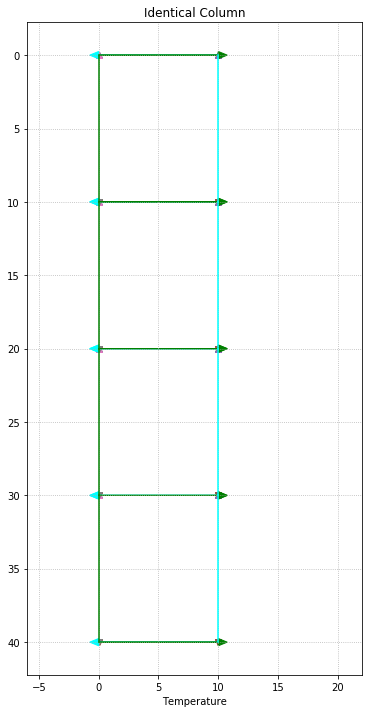

In [14]:
plt.figure(figsize=(6,12))
plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t+10, Tr+10, Tr_b+10, PoR_abs, KoR,
                      zl_t, zl_c, zl_b, Tl_t, Tl, Tl_b, PoL_abs, KoL, search_dir)
plt.xlim((-6,22))
plt.title('Identical Column')

In [15]:
print(df_unstratified)

    KoL  KoR  PoL  PoR    hL    hR    zl    zr
0     1    1  0.0  0.0   0.0   0.0   0.0   0.0
1     1    1  0.0  0.0   0.0   0.0   0.0   0.0
2     1    1  1.0  1.0  10.0  10.0  10.0  10.0
3     1    1  1.0  1.0   0.0   0.0  10.0  10.0
4     1    2  1.0  0.0   0.0   0.0  10.0  10.0
5     2    2  0.0  0.0   0.0   0.0  10.0  10.0
6     2    2  1.0  1.0  10.0  10.0  20.0  20.0
7     2    2  1.0  1.0   0.0   0.0  20.0  20.0
8     2    3  1.0  0.0   0.0   0.0  20.0  20.0
9     3    3  0.0  0.0   0.0   0.0  20.0  20.0
10    3    3  1.0  1.0  10.0  10.0  30.0  30.0
11    3    3  1.0  1.0   0.0   0.0  30.0  30.0
12    3    4  1.0  0.0   0.0   0.0  30.0  30.0
13    4    4  0.0  0.0   0.0   0.0  30.0  30.0
14    4    4  1.0  1.0  10.0  10.0  40.0  40.0
15    4    4  1.0  1.0   0.0   0.0  40.0  40.0


# Mixed Layer on Right


Working on k_surface 0: Tl[0,0]: 14.000000 Tr[0,0]: 14.000000 dRho: 0.000000
Searching from right layer 0 Interface 0
Searching in left layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
At top or dRhoTop>0
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000

Working on k_surface 1: Tl[0,0]: 14.000000 Tr[0,1]: 14.000000 dRho: 0.000000
Searching from left layer 0 interface 0
Searching in right layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
Layer perfectly unstratified, different search direction
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000
hL: 0.000000 hR: 0.000000 hEff: 0.000000

Working on k_surface 2: Tl[0,1]: 14.000000 Tr[0,1]: 14.000000 dRho: 0.000000
Searching from right layer 0 Interface 1
Searching in left layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
Layer perfectly unstratified, different search direction
Search top of next layer 1
Position on left layer 0: 1.000000
Position on rig

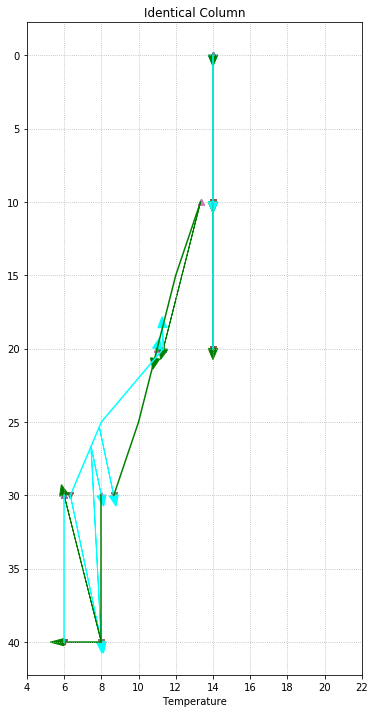

In [16]:
reload(set_neutral_position)
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Tr = np.array([14., 14., 8., 6.,])
Tl = np.array([14., 12., 10., 8.,])
Sl_t = np.zeros(hl.size) ; Sl_b = np.zeros(hl.size)
Sr_t = np.zeros(hl.size) ; Sr_b = np.zeros(hl.size)
drdt_lt = -1*np.ones(hl.size) ; drdt_lb = -1*np.ones(hl.size)
drds_lt = np.zeros(hl.size) ; drds_lb = np.zeros(hl.size)
drdt_rt = -1*np.ones(hl.size) ; drdt_rb = -1*np.ones(hl.size)
drds_rt = np.zeros(hl.size) ; drds_rb = np.zeros(hl.size)
zil, zl_t, zl_b, zl_c, Tl_t, Tl_b = construct_column(hl, Tl)
zir, zr_t, zr_b, zr_c, Tr_t, Tr_b = construct_column(hr, Tr)
PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR, search_dir = set_neutral_position.set_neutral_surface_position2(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb)
df_mixed_layer_right = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})
plt.figure(figsize=(6,12))
plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                      zl_t, zl_c, zl_b, Tl_t, Tl, Tl_b, PoL_abs, KoL, search_dir)
plt.xlim((4,22))
plt.title('Identical Column')
print(hEff.sum())

In [17]:
print(df_mixed_layer_right)

    KoL  KoR       PoL       PoR        hL         hR        zl         zr
0     1    1  0.000000  0.000000   0.00000   0.000000   0.00000   0.000000
1     1    1  0.000000  0.000000   0.00000   0.000000   0.00000   0.000000
2     1    1  1.000000  1.000000  10.00000  10.000000  10.00000  10.000000
3     1    1  1.000000  1.000000   0.00000   0.000000  10.00000  10.000000
4     1    2  1.000000  0.000000   0.00000   0.000000  10.00000  10.000000
5     1    2  1.000000  1.000000   0.00000  10.000000  10.00000  20.000000
6     2    3  0.000000  0.000000   0.00000   0.000000  10.00000  20.000000
7     2    3  0.857143  0.000000   8.57143   0.000000  18.57143  20.000000
8     2    3  1.000000  0.066667   1.42857   0.666666  20.00000  20.666666
9     3    3  0.000000  0.066667   0.00000   0.000000  20.00000  20.666666
10    3    3  1.000000  0.533333  10.00000   4.666666  30.00000  25.333333
11    4    3  0.000000  0.666667   0.00000   1.333334  30.00000  26.666667
12    4    3  1.000000  0

# Right column with unstable mixed layer

In [18]:
reload(set_neutral_position)
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Tr = np.array([14., 14., 8., 6.,])
Tl = np.array([12., 16., 10., 8.,])
Sl_t = np.zeros(hl.size) ; Sl_b = np.zeros(hl.size)
Sr_t = np.zeros(hl.size) ; Sr_b = np.zeros(hl.size)
drdt_lt = -1*np.ones(hl.size) ; drdt_lb = -1*np.ones(hl.size)
drds_lt = np.zeros(hl.size) ; drds_lb = np.zeros(hl.size)
drdt_rt = -1*np.ones(hl.size) ; drdt_rb = -1*np.ones(hl.size)
drds_rt = np.zeros(hl.size) ; drds_rb = np.zeros(hl.size)
zil, zl_t, zl_b, zl_c, Tl_t, Tl_b = construct_column(hl, Tl)
zir, zr_t, zr_b, zr_c, Tr_t, Tr_b = construct_column(hr, Tr)
PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR, search_dir = set_neutral_position.set_neutral_surface_position2(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb)
df_unstable_mixed_layer_right = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})
print(hEff.sum())


Working on k_surface 0: Tl[0,0]: 12.000000 Tr[0,0]: 14.000000 dRho: -2.000000
Searching from right layer 0 Interface 0
Searching in left layer 0: dRhoTop: 2.000000 dRhoBot: 2.000000
At top or dRhoTop>0
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000

Working on k_surface 1: Tl[0,0]: 12.000000 Tr[0,1]: 14.000000 dRho: -2.000000
Searching from right layer 0 Interface 1
Searching in left layer 0: dRhoTop: 2.000000 dRhoBot: 2.000000
At top or dRhoTop>0
Search top of next layer 1
Position on left layer 0: 0.000000
Position on right layer 0: 1.000000
hL: 0.000000 hR: 10.000000 hEff: 0.000000

Working on k_surface 2: Tl[0,0]: 12.000000 Tr[1,0]: 14.000000 dRho: -2.000000
Searching from right layer 1 Interface 0
Searching in left layer 0: dRhoTop: 2.000000 dRhoBot: 2.000000
At top or dRhoTop>0
Search bottom of same layer 1
Position on left layer 0: 0.000000
Position on right layer 1: 0.000000
hL: 0.000000 hR: 0.000000 hEff: 0.000000

Working

Surface 0: 12.0 14.0 0.0 0.0
Surface 1: 12.0 14.0 0.0 10.0
Surface 2: 12.0 14.0 0.0 10.0
Surface 3: 12.0 14.0 0.0 20.0
Surface 4: 12.0 11.3333 0.0 20.0
Surface 5: 12.0 11.3333 10.0 20.0
Surface 6: 16.0 11.3333 10.0 20.0
Surface 7: 16.0 11.3333 20.0 20.0
Surface 8: 13.3333 11.3333 20.0 20.0
Surface 9: 10.666666030883789 11.3333 24.0000011444 20.0
Surface 10: 8.33333 7.666666507720947 30.0 26.0000005722
Surface 11: 8.0 7.4444444974263515 30.0 26.6666666667
Surface 12: 8.0 7.4444444974263515 40.0 26.6666666667
Surface 13: 8.0 6.33333 40.0 30.0
Surface 14: 8.0 6.0 40.0 30.0
Surface 15: 8.0 6.0 40.0 40.0


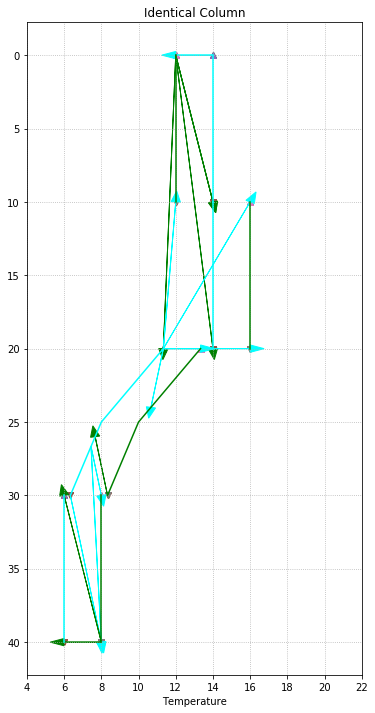

In [19]:
plt.figure(figsize=(6,12))
plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                      zl_t, zl_c, zl_b, Tl_t, Tl, Tl_b, PoL_abs, KoL, search_dir)
plt.xlim((4,22))
plt.title('Identical Column')

In [20]:
print(df_unstable_mixed_layer_right)

    KoL  KoR  PoL       PoR         hL         hR         zl         zr
0     1    1  0.0  0.000000   0.000000   0.000000   0.000000   0.000000
1     1    1  0.0  1.000000   0.000000  10.000000   0.000000  10.000000
2     1    2  0.0  0.000000   0.000000   0.000000   0.000000  10.000000
3     1    2  0.0  1.000000   0.000000  10.000000   0.000000  20.000000
4     1    3  0.0  0.000000   0.000000   0.000000   0.000000  20.000000
5     1    3  1.0  0.000000  10.000000   0.000000  10.000000  20.000000
6     2    3  0.0  0.000000   0.000000   0.000000  10.000000  20.000000
7     2    3  1.0  0.000000  10.000000   0.000000  20.000000  20.000000
8     3    3  0.0  0.000000   0.000000   0.000000  20.000000  20.000000
9     3    3  0.4  0.000000   4.000001   0.000000  24.000001  20.000000
10    3    3  1.0  0.600000   5.999999   6.000001  30.000000  26.000001
11    4    3  0.0  0.666667   0.000000   0.666666  30.000000  26.666667
12    4    3  1.0  0.666667  10.000000   0.000000  40.000000  26